## 1. Libraries Import

In [33]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import warnings

warnings.filterwarnings("ignore")

## 2. Load MovieLens Dataset

In [4]:
# Define file paths
ratings_file = '../data/ratings.dat'
users_file = '../data/users.dat'
movies_file = '../data/movies.dat'

# Define column names
ratings_cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']
users_cols = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
movies_cols = ['MovieID', 'Title', 'Genres']

try:
    # Load datasets
    ratings = pd.read_csv(ratings_file, sep='::', names=ratings_cols, engine='python')
    users = pd.read_csv(users_file, sep='::', names=users_cols, engine='python')
    movies = pd.read_csv(movies_file, sep='::', names=movies_cols, engine='python', encoding="ISO-8859-1")
except FileNotFoundError as e:
    print("File not found. Please check the file paths.")
    raise e

## 3. Data Preprocessing

### 3.1. Preprocess User Features

In [38]:
# Encode categorical and normalize numerical features
users['Gender'] = LabelEncoder().fit_transform(users['Gender'])  # M:1, F:0
users['Occupation'] = LabelEncoder().fit_transform(users['Occupation'])
scaler = StandardScaler()
users['Age'] = scaler.fit_transform(users[['Age']])

# Create user feature matrix
user_features = torch.tensor(users[['Gender', 'Age', 'Occupation']].values, dtype=torch.float)

### 3.2. Preprocess Movie Features

In [39]:
# Handle NaN or missing Genres
def safe_split(genres):
    return genres.split('|') if isinstance(genres, str) else []

movies['Genres'] = movies['Genres'].apply(safe_split)
all_genres = set(g for genres in movies['Genres'] for g in genres)
genre_mapping = {genre: idx for idx, genre in enumerate(sorted(all_genres))}

# Convert genres to one-hot vectors
genre_matrix = np.zeros((len(movies), len(all_genres)))
for idx, genres in enumerate(movies['Genres']):
    genre_matrix[idx, [genre_mapping[g] for g in genres]] = 1

movie_features = torch.tensor(genre_matrix, dtype=torch.float)

## 4. Graph Construction

### 4.1. Map User and Movie IDs to Node Indices

In [40]:
# Map UserID and MovieID to indices
user_id_map = {id_: idx for idx, id_ in enumerate(users['UserID'])}
movie_id_map = {id_: idx + len(user_id_map) for idx, id_ in enumerate(movies['MovieID'])}

# Map IDs to indices in ratings
ratings['UserNode'] = ratings['UserID'].map(user_id_map)
ratings['MovieNode'] = ratings['MovieID'].map(movie_id_map)

if ratings[['UserNode', 'MovieNode']].isnull().any().any():
    print("Some UserID or MovieID in ratings are not mapped. Check data consistency.")
    ratings.dropna(subset=['UserNode', 'MovieNode'], inplace=True)

### 4.2. Create Edge Indices and Edge Attributes

In [41]:
# Pad user features to match movie features dimension
if user_features.shape[1] < movie_features.shape[1]:
    user_features_padded = F.pad(user_features, (0, movie_features.shape[1] - user_features.shape[1]))
elif user_features.shape[1] > movie_features.shape[1]:
    movie_features = F.pad(movie_features, (0, user_features.shape[1] - movie_features.shape[1]))
else:
    user_features_padded = user_features

# Concatenate padded user features and movie features
node_features = torch.cat([user_features_padded, movie_features], dim=0)

# Create edge index
edge_index = torch.tensor(ratings[['UserNode', 'MovieNode']].values.T, dtype=torch.long)

# Use ratings as edge attributes
edge_attr = torch.tensor(ratings['Rating'].values, dtype=torch.float)

## 5. Generate Negative Samples

In [42]:
def generate_negative_edges(num_users, num_movies, existing_edges, num_samples):
    existing_edge_set = set((u, m) for u, m in existing_edges)
    negative_edges = []
    
    while len(negative_edges) < num_samples:
        u = np.random.randint(0, num_users)
        m = np.random.randint(0, num_movies)
        edge = (u, m + num_users)  # Offset movie indices
        if edge not in existing_edge_set:
            negative_edges.append(edge)
            existing_edge_set.add(edge)
    
    return torch.tensor(negative_edges).T

num_negative_samples = edge_index.size(1)
negative_edges = generate_negative_edges(len(user_id_map), len(movie_id_map), edge_index.T.tolist(), num_negative_samples)

In [43]:
# Combine positive and negative edges
combined_edges = torch.cat([edge_index, negative_edges], dim=1)
edge_labels = torch.cat([torch.ones(edge_index.size(1)), torch.zeros(negative_edges.size(1))])

## 6. Define the GNN Model

In [44]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

## 7. Train-Test Split

In [45]:
# Train-Test Split
train_edges, test_edges, train_labels, test_labels = train_test_split(
    combined_edges.T, edge_labels, test_size=0.2, random_state=42
)

train_edges = torch.tensor(train_edges).T
test_edges = torch.tensor(test_edges).T
train_labels = torch.tensor(train_labels, dtype=torch.float)
test_labels = torch.tensor(test_labels, dtype=torch.float)

## 8. Define Training and Evaluation Functions

In [56]:
def precision_at_k(predictions, ground_truth, k):
    top_k = torch.topk(predictions, k).indices
    hits = ground_truth[top_k].sum()
    return hits / k

In [57]:
def ndcg_at_k(predictions, ground_truth, k):
    top_k = torch.topk(predictions, k).indices
    dcg = sum(
        (ground_truth[top_k[i]] / torch.log2(torch.tensor(i + 2).float()))
        for i in range(len(top_k))
    )
    ideal_dcg = sum(1.0 / torch.log2(torch.tensor(i + 2).float()) for i in range(min(k, ground_truth.sum().int())))
    return dcg / ideal_dcg if ideal_dcg > 0 else 0.0

In [58]:
def calculate_metrics(preds, labels):
    preds = preds.detach().cpu().numpy()
    labels = labels.cpu().numpy()
    binary_preds = (preds >= 0.5).astype(int)
    precision = precision_score(labels, binary_preds)
    recall = recall_score(labels, binary_preds)
    f1 = f1_score(labels, binary_preds)
    auc = roc_auc_score(labels, preds)
    return precision, recall, f1, auc

In [59]:
def calculate_ranking_metrics(preds, labels, k=10):
    preds = preds.detach()
    labels = labels.detach()
    precision_k = precision_at_k(preds, labels, k)
    ndcg_k = ndcg_at_k(preds, labels, k)
    return precision_k, ndcg_k

In [60]:
def train():
    model.train()
    optimizer.zero_grad()
    embeddings = model(node_features, train_edges)
    user_embeds = embeddings[train_edges[0]]
    movie_embeds = embeddings[train_edges[1]]
    preds = (user_embeds * movie_embeds).sum(dim=1).sigmoid()
    loss = criterion(preds, train_labels)
    loss.backward()
    optimizer.step()
    precision, recall, f1, auc = calculate_metrics(preds, train_labels)
    precision_k, ndcg_k = calculate_ranking_metrics(preds, train_labels)
    return loss.item(), precision, recall, f1, auc, precision_k, ndcg_k

In [61]:
def evaluate():
    model.eval()
    with torch.no_grad():
        embeddings = model(node_features, test_edges)
        user_embeds = embeddings[test_edges[0]]
        movie_embeds = embeddings[test_edges[1]]
        preds = (user_embeds * movie_embeds).sum(dim=1).sigmoid()
        loss = criterion(preds, test_labels)
        precision, recall, f1, auc = calculate_metrics(preds, test_labels)
        precision_k, ndcg_k = calculate_ranking_metrics(preds, test_labels)
    return loss.item(), precision, recall, f1, auc, precision_k, ndcg_k

## 9. Model Training

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(input_dim=node_features.size(1), hidden_dim=128, output_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

node_features = node_features.to(device)
train_edges, test_edges = train_edges.to(device), test_edges.to(device)
train_labels, test_labels = train_labels.to(device), test_labels.to(device)

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

for epoch in range(1, 21):
    train_loss, train_precision, train_recall, train_f1, train_auc, train_precision_k, train_ndcg_k = train()
    test_loss, test_precision, test_recall, test_f1, test_auc, test_precision_k, test_ndcg_k = evaluate()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append((train_precision, train_recall, train_f1, train_auc, train_precision_k, train_ndcg_k))
    test_metrics.append((test_precision, test_recall, test_f1, test_auc, test_precision_k, test_ndcg_k))

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Train Metrics - Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}, Precision@K: {train_precision_k:.4f}, NDCG@K: {train_ndcg_k:.4f}")
    print(f"Test Metrics  - Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}, Precision@K: {test_precision_k:.4f}, NDCG@K: {test_ndcg_k:.4f}")

Epoch 01 | Train Loss: 29.0988, Test Loss: 1.2911
Train Metrics - Precision: 0.5002, Recall: 1.0000, F1: 0.6668, AUC: 0.4858, Precision@K: 0.3000, NDCG@K: 0.2835
Test Metrics  - Precision: 0.4974, Recall: 0.5385, F1: 0.5171, AUC: 0.5025, Precision@K: 0.1000, NDCG@K: 0.1389
Epoch 02 | Train Loss: 1.2876, Test Loss: 8.0035
Train Metrics - Precision: 0.4995, Recall: 0.5350, F1: 0.5167, AUC: 0.5026, Precision@K: 0.1000, NDCG@K: 0.0851
Test Metrics  - Precision: 0.5227, Recall: 0.1373, F1: 0.2175, AUC: 0.5101, Precision@K: 0.1000, NDCG@K: 0.0851
Epoch 03 | Train Loss: 7.9718, Test Loss: 4.4455
Train Metrics - Precision: 0.5198, Recall: 0.1347, F1: 0.2140, AUC: 0.5092, Precision@K: 0.2000, NDCG@K: 0.1370
Test Metrics  - Precision: 0.5210, Recall: 0.1414, F1: 0.2224, AUC: 0.5111, Precision@K: 0.1000, NDCG@K: 0.0851
Epoch 04 | Train Loss: 4.4254, Test Loss: 2.3387
Train Metrics - Precision: 0.5181, Recall: 0.1396, F1: 0.2200, AUC: 0.5102, Precision@K: 0.4000, NDCG@K: 0.2727
Test Metrics  - Pre

## 10. Visualization

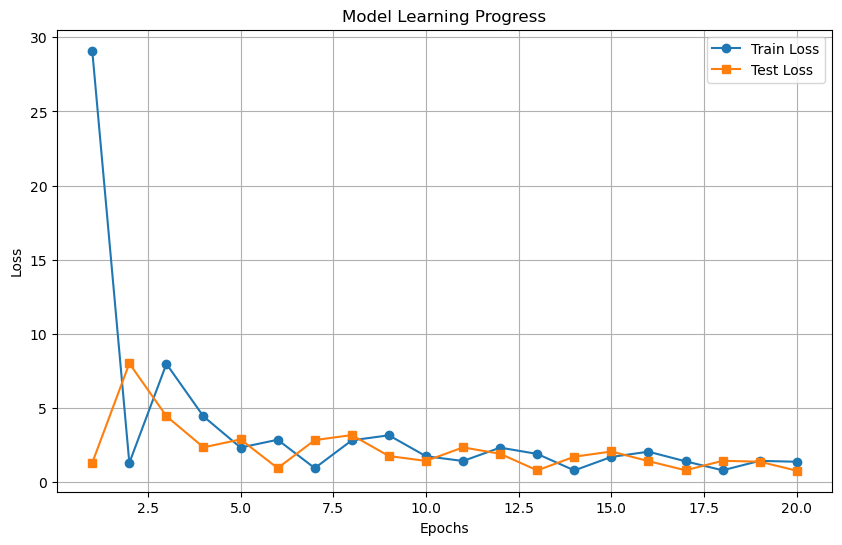

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, 21), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Learning Progress')
plt.legend()
plt.grid(True)
plt.show()

## 11. Evaluation Metrics

In [64]:
final_train_metrics = train_metrics[-1]
final_test_metrics = test_metrics[-1]

print("\nFinal Train Metrics:")
print(f"Precision: {final_train_metrics[0]:.4f}, Recall: {final_train_metrics[1]:.4f}, F1: {final_train_metrics[2]:.4f}, AUC: {final_train_metrics[3]:.4f}, Precision@K: {final_train_metrics[4]:.4f}, NDCG@K: {final_train_metrics[5]:.4f}")

print("\nFinal Test Metrics:")
print(f"Precision: {final_test_metrics[0]:.4f}, Recall: {final_test_metrics[1]:.4f}, F1: {final_test_metrics[2]:.4f}, AUC: {final_test_metrics[3]:.4f}, Precision@K: {final_test_metrics[4]:.4f}, NDCG@K: {final_test_metrics[5]:.4f}")


Final Train Metrics:
Precision: 0.5030, Recall: 0.9684, F1: 0.6621, AUC: 0.5144, Precision@K: 0.9000, NDCG@K: 0.8900

Final Test Metrics:
Precision: 0.5153, Recall: 0.8355, F1: 0.6375, AUC: 0.5387, Precision@K: 0.3000, NDCG@K: 0.2182
